# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import warnings
import math
import calendar

from scipy.stats import boxcox, yeojohnson

#pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 50)
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_pickle('./Datasets/train.pickle')

### Initial Analysis

In [3]:
# Our train dataset has 12,792 articles
train.shape

(12792, 12)

In [4]:
# Our train dataset has 12 features which are ordinal, continous and text-based features.
train.columns

Index(['newsdesk', 'section', 'subsection', 'material', 'headline', 'abstract',
       'keywords', 'word_count', 'pub_date', 'is_popular', 'n_comments',
       'uniqueID'],
      dtype='object')

In [5]:
train.head(3)

,newsdesk,section,subsection,material,headline,abstract,keywords,word_count,pub_date,is_popular,n_comments,uniqueID
0,Editorial,Opinion,NaN,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"[Veterans, For-Profit Schools, Financial Aid (...",680,2020-01-01 00:18:54+00:00,1,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...
1,Games,Crosswords & Games,NaN,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,[Crossword Puzzles],931,2020-01-01 03:00:10+00:00,1,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...
2,Science,Science,NaN,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","[Meteors and Meteorites, Space and Astronomy, ...",1057,2020-01-01 05:00:08+00:00,0,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...


In [6]:
# We have 62 unique newsdesks, 41 sections, and 61 subsections
train['newsdesk'].nunique(), train['section'].nunique(), train['subsection'].nunique()

(62, 41, 61)

#### Checking for Null Values

Almost 2/3 of our subsection data is null. Subsection will likely be strong predictor so we're going to keep this feature.

In [7]:
# Checking for null values
train.isnull().sum()[train.isnull().sum() > 0]

subsection    8525
dtype: int64

#### Checking for Duplicates

There are a couple of duplicated headlines in our data. These are likely recurring weekly or monthly articles.

In [8]:
# Checking for duplicated values
train['headline'].duplicated().sum()

160

In [9]:
train[train['headline'].duplicated()]['headline'].value_counts().head(5)

Coronavirus in N.Y.C.: Latest Updates               31
Variety: Acrostic                                   19
What the Heck Is That?                              13
Homes for Sale in New York and New Jersey           10
Homes for Sale in Brooklyn, Queens and Manhattan     8
Name: headline, dtype: int64

In [10]:
# They're generally pretty unpopular
train[train['headline'].duplicated() == True]['is_popular'].value_counts()

0    154
1      6
Name: is_popular, dtype: int64

## Popularity vs Number of Comments

There's a large group of articles that have less than 90 comments -- this is where I chose to split the data. We can see that `n_comments` has a heavy positive skew, with the number of articles decreasing in proportion to the number of comments.

It's important to note here that not all NYT articles are open for comments. The NYT moderation team chooses articles to open for public commentary. Our data only reflects articles that were opened for commentary AND recieved at least one comment.

In [11]:
# Average number of comments
train['n_comments'].mean()

305.8529549718574

Text(0.5, 1.0, 'Number of Comments')

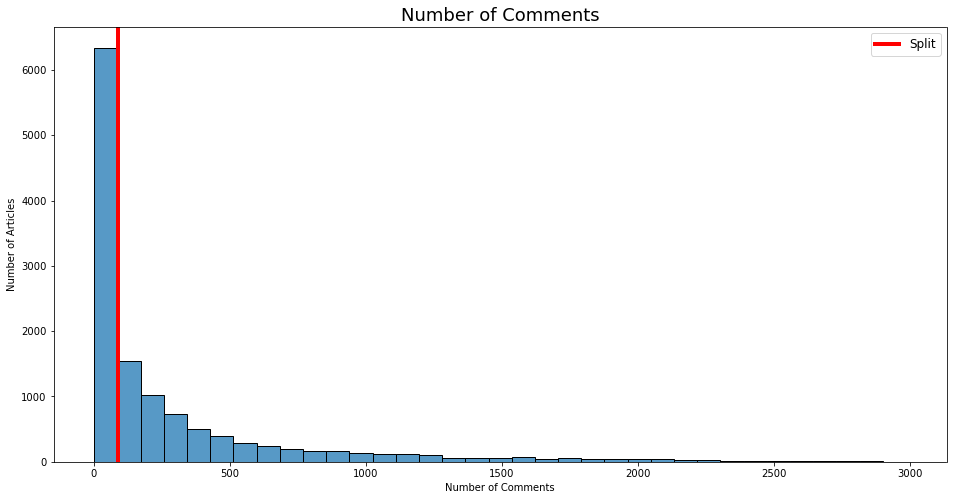

In [12]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
sns.histplot(train['n_comments'].drop(train[train['n_comments'] > 3000].index), bins=35)
mean = train['n_comments'].mean()
plt.axvline(90, ls='-', c='red', label='Split', lw=4)
plt.legend(fontsize=12, loc=1)
plt.xlabel('Number of Comments')
plt.ylabel('Number of Articles')
plt.title(f'Number of Comments', fontsize=18)
#plt.savefig('comments', dpi=180)

### Checking Class Balance

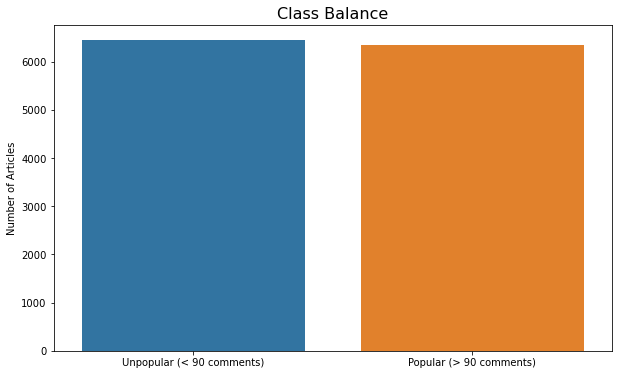

In [13]:
plt.figure(figsize=(10,6))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Overall, our classes are pretty much evenly balanced
    g = sns.countplot(train['is_popular'])
    g.set_xticklabels(['Unpopular (< 90 comments)', 'Popular (> 90 comments)'])
    plt.xlabel('')
    plt.ylabel('Number of Articles')
    plt.title('Class Balance', fontsize=16);

In [14]:
train['is_popular'].value_counts(normalize=True)

0    0.503752
1    0.496248
Name: is_popular, dtype: float64

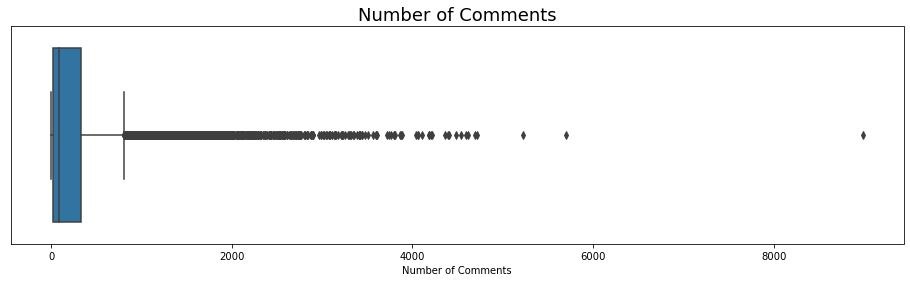

In [15]:
# There are a few extreme outliers in our data
plt.figure(figsize=(16,4))
sns.boxplot(data=train['n_comments'], orient='h')
plt.xlabel('n_comments')
plt.yticks([])
plt.xlabel('Number of Comments')
plt.title('Number of Comments', fontsize=18);

In [16]:
# Top 3 outliers
train[train['n_comments'] > 4000][['headline', 'abstract', 'n_comments', 'pub_date']] \
.sort_values(by='n_comments', ascending=False).head(3)

,headline,abstract,n_comments,pub_date
12618,Trump’s Taxes Show Chronic Losses and Years of...,The Times obtained Donald Trump’s tax informat...,8987,2020-09-27 21:07:33+00:00
2436,Bernie Sanders Is Making a Big Mistake,It has to do with respect.,5702,2020-02-23 23:33:29+00:00
6154,"Democrats, It’s Time to Consider a Plan B",Tara Reade’s allegations against Joe Biden dem...,5228,2020-05-03 19:00:07+00:00


## Word Count

Dealing with word count is slightly tricky. We can see that the feature is normally distributed in general with a heavy positive skew. We can also see that there are a large number of articles that have a word count of 0. These are interactive features that don't have 'words' in the conventional sense. Because this is not technically 'missing' data, I'm not going to impute it.

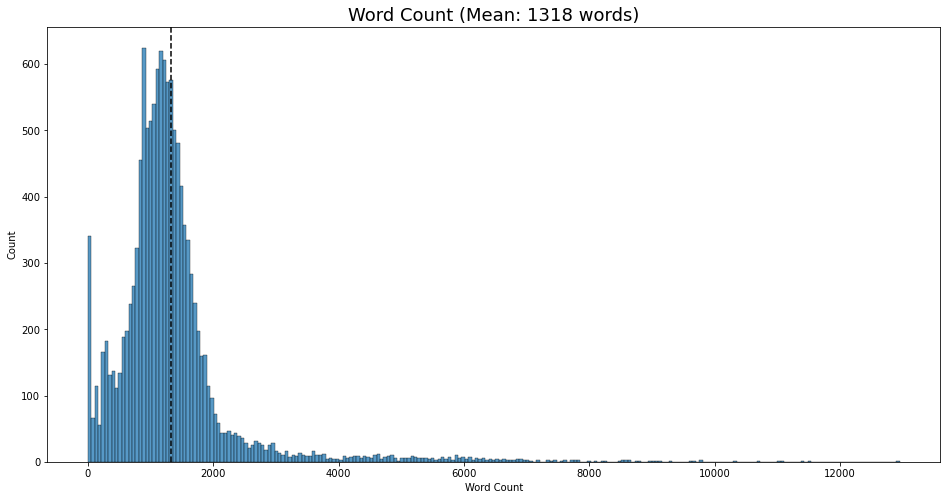

In [17]:
# Close to a normal distribution, with a positive skew
plt.figure(figsize=(16,8))
mean = train['word_count'].mean()
plt.axvline(mean, ls='--', color='black')
sns.histplot(train['word_count'])
plt.xlabel('Word Count')
plt.title(f'Word Count (Mean: {mean:.0f} words)', fontsize=18);

In general, machine learning algorithms tend to perform better when the distribution of variables is normal -- in other words, performance tends to improve for variables that have a standard distribution.

#### Feature Transformation

In [18]:
def transform_var(col, df):
    skew_dict = {} # Creating dictionary to store skew values
    df[f'{col}_log'] = np.log1p(df[f'{col}'])
    df[f'{col}_box'] = df[f'{col}'].replace(0, 0.001) # Replacing as Boxcox can't transform values that are 0
    df[f'{col}_box'] = boxcox(df[f'{col}_box'])[0]
    df[f'{col}_sqrt'] = np.sqrt(df[f'{col}'])
    
    skew_dict['Original'] = df[f'{col}'].skew()
    skew_dict['Log1p'] = df[f'{col}_log'].skew()
    skew_dict['Boxcox'] = df[f'{col}_box'].skew()
    skew_dict['Square Root'] = df[f'{col}_sqrt'].skew()
    return skew_dict

In [19]:
def plot_transform(col, df):
    fig, ax = plt.subplots(2, 2, figsize=(13,9), sharey=True)
    ax = ax.ravel()
    sns.histplot(df[f'{col}'], ax=ax[0])
    ax[0].set_title(f"Original (Skew: {skew_dict['Original']:.3f})", fontsize=14)
    sns.histplot(df[f'{col}_log'], ax=ax[1])
    ax[1].set_title(f"Log1p (Skew: {skew_dict['Log1p']:.3f})", fontsize=14)
    sns.histplot(df[f'{col}_box'], ax=ax[2])
    ax[2].set_title(f"Boxcox (Skew: {skew_dict['Boxcox']:.3f})", fontsize=14)
    sns.histplot(df[f'{col}_sqrt'], ax=ax[3])
    ax[3].set_title(f"Square Root (Skew: {skew_dict['Square Root']:.3f})", fontsize=14)
    for ax in ax:
        ax.set_xlabel('')
        ax.set_ylabel('')
    plt.suptitle('Transformed Word Count', fontsize=18)
    plt.tight_layout()

Here, we can see the effectiveness of various transformation methods. The Boxcox transformation seems to work best here -- our data is still slightly skewed but much closer to a normal distribution.

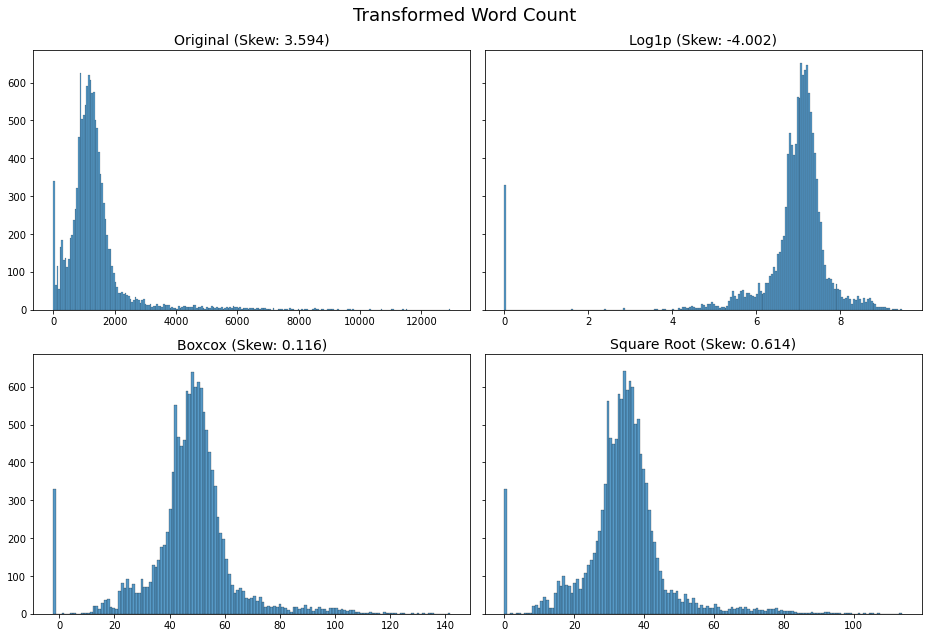

In [20]:
skew_dict = transform_var('word_count', train)
plot_transform('word_count', train)

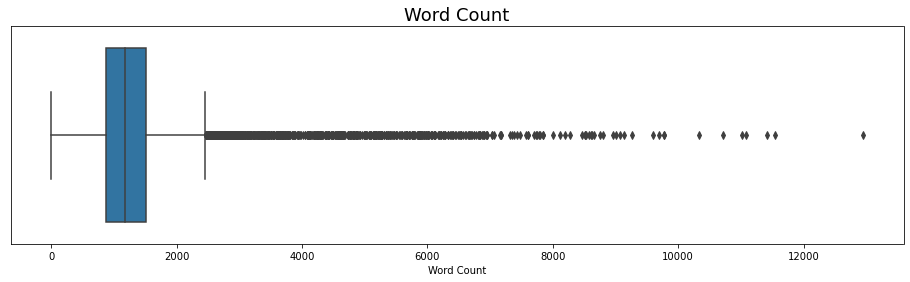

In [21]:
# There are a few extreme outliers in our data
plt.figure(figsize=(16,4))
sns.boxplot(data=train['word_count'], orient='h')
plt.yticks([])
plt.xlabel('Word Count')
plt.title('Word Count', fontsize=18);

### Interactive Features

In [22]:
# Stories with a word count of 0 seem to be interactive features
train[train['word_count'] == 0] \
    [['headline', 'newsdesk', 'section', 'material', 'word_count']].head()

,headline,newsdesk,section,material,word_count
3,Sync your calendar with the solar system,Science,Science,Interactive Feature,0
80,The Countdown,Opinion,Opinion,Interactive Feature,0
81,Parent-Teacher Association,Opinion,Opinion,Interactive Feature,0
82,"We Asked You to Name These Athletes, Politicia...",The Upshot,The Upshot,Interactive Feature,0
97,Tell Me Everything,Opinion,Opinion,Interactive Feature,0


In [23]:
# All articles with a word count of 0 are interactive features
train[train['word_count'] == 0]['material'].value_counts()

Interactive Feature    330
Name: material, dtype: int64

In [24]:
# They mostly come from these particular newsdesks
train[train['word_count'] == 0]['newsdesk'].value_counts().head(5)

Magazine      92
U.S.          69
Opinion       47
The Upshot    41
Climate       18
Name: newsdesk, dtype: int64

In [25]:
# 'The Upshot' and 'Opinion' appear to be newsdesks specifically created for interactive features
train['newsdesk'].value_counts()[train['newsdesk'].value_counts().index.str.contains('Upshot|Magazine|U.S.|Op|Clim')]

OpEd          1556
Magazine       342
Upshot         202
Climate        103
U.S.            69
Opinion         47
The Upshot      41
Name: newsdesk, dtype: int64

In [26]:
# They generally seem to be more popular than the average article
train[train['word_count'] == 0][['is_popular']].mean()

is_popular    0.651515
dtype: float64

### Number of Comments versus Word Count

Does word count, or the length of an article affect the number of comments on each article? In the plot below, we can see that there's generally a positive relationship between these two variables, except for OpEd articles where it seems that word count doesn't affect number of comments at all. OpEd articles have an average of around 1100 words.

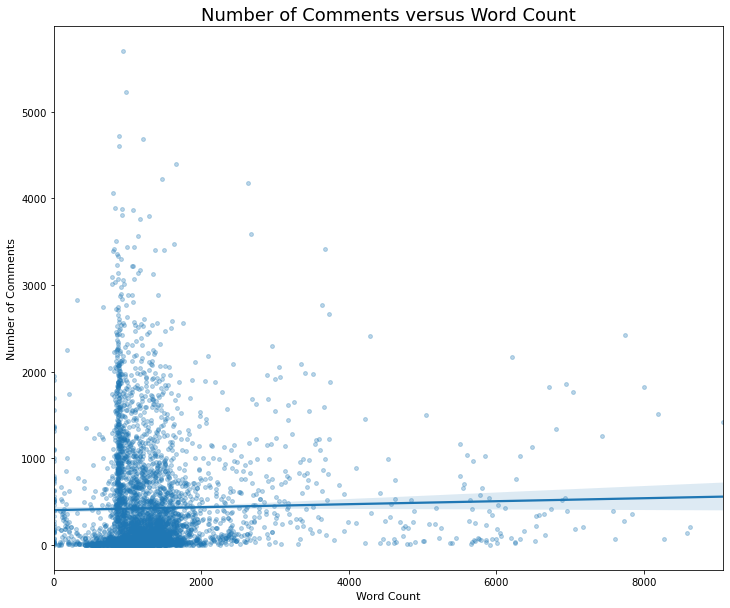

In [27]:
# Combining different newsdesk names
plt.figure(figsize=(12, 10))
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'The Upshot' if x=='Upshot' else x)
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'OpEd' if x=='Opinion' else x)
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'AtHome' if x=='At Home' else x)
top_news_df = train['newsdesk'].value_counts().head(5).index

# OpEd length doesn't affect number of comments -- but longer news from the Washington desk does
g = sns.regplot(data=train.loc[train['newsdesk'].isin(top_news_df)], x='word_count', y='n_comments', 
               scatter_kws={'alpha':0.3, 's':15})

plt.ylabel('Number of Comments', fontsize=11)
plt.xlabel('Word Count', fontsize=11)
#plt.axhline(90, ls='--', color='black')
plt.title('Number of Comments versus Word Count', fontsize=18);

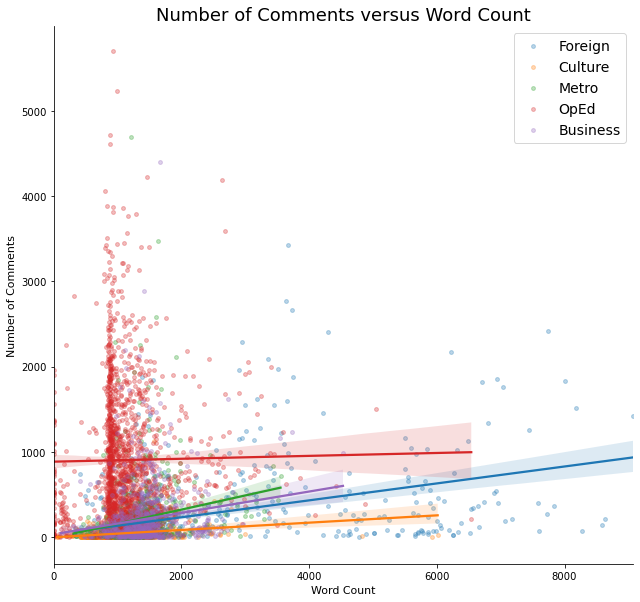

In [28]:
# Combining different newsdesk names
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'The Upshot' if x=='Upshot' else x)
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'OpEd' if x=='Opinion' else x)
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'AtHome' if x=='At Home' else x)
top_news_df = train['newsdesk'].value_counts().head(5).index

# OpEd length doesn't affect number of comments -- but longer news from the Washington desk does
g = sns.lmplot(data=train.loc[train['newsdesk'].isin(top_news_df)], x='word_count', y='n_comments', 
               hue='newsdesk', palette='tab10', height=8, aspect=1.10, scatter_kws={'alpha':0.3, 's':15}, legend_out=False)

for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [20] 

g._legend.set_title('News Desk')

plt.ylabel('Number of Comments', fontsize=11)
plt.xlabel('Word Count', fontsize=11)
plt.legend(fontsize=14)
plt.title('Number of Comments versus Word Count', fontsize=18);

In [29]:
# There's a moderate positive correlation between these two variables
train.corr()['is_popular']['word_count']

0.1713162393600203

From this point, I'll be shifting to looking at popularity (as denoted by `is_popular`) instead of number of comments.

In [30]:
# We won't be using number of comments moving forward
train = train.drop(columns=['n_comments'])

## Headline / Abstract Length

In [31]:
train['headline_len'] = train['headline'].apply(lambda x: len(x))
train['abstract_len'] = train['abstract'].apply(lambda x: len(x))
train['head_abs_len'] = train['headline_len'] + train['abstract_len']

### Headline Length

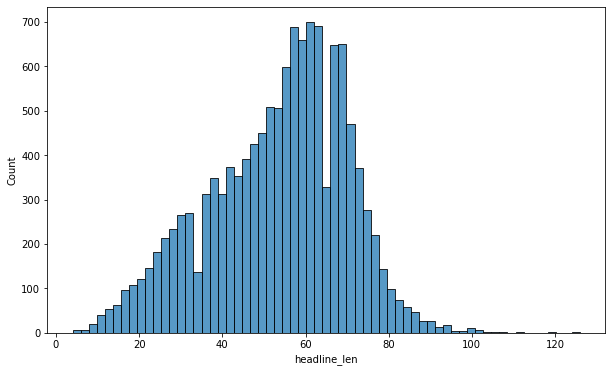

In [32]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='headline_len');

Text(0.5, 1.0, 'Average Popularity vs Headline Length')

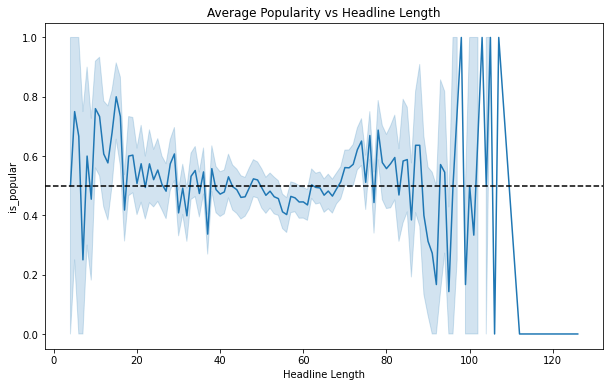

In [33]:
plt.figure(figsize=(10,6))
sns.lineplot(data=train, x='headline_len', y='is_popular')
mean = train.groupby('headline_len').mean()['is_popular'].mean()
#plt.axhline(mean, color='black', ls='--', label=f'Avg. Popularity: {mean:.2f}')
#plt.legend(fontsize=12)
plt.axhline(0.5, color='black', ls='--')
plt.xlabel('Headline Length')
plt.title('Average Popularity vs Headline Length')

### Abstract Length

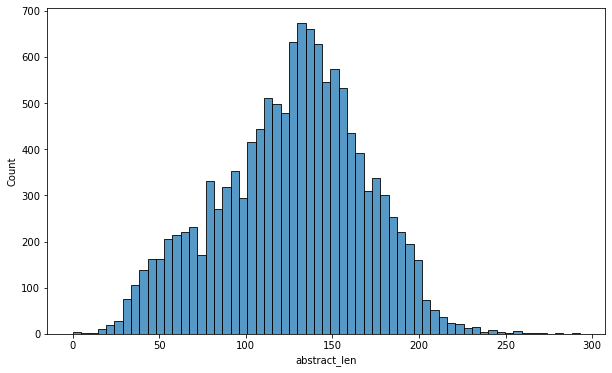

In [34]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='abstract_len');

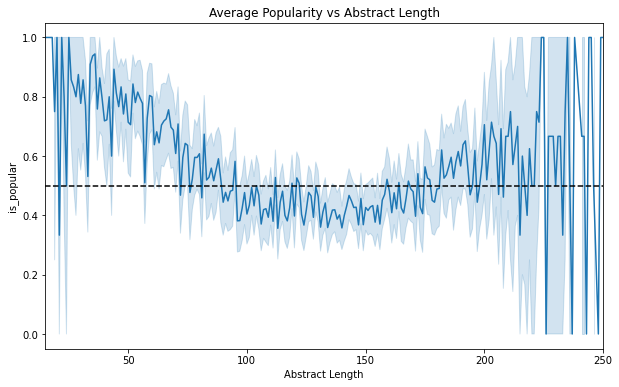

In [35]:
plt.figure(figsize=(10,6))
sns.lineplot(data=train, x='abstract_len', y='is_popular')
mean = train.groupby('abstract_len').mean()['is_popular'].mean()
plt.axhline(0.5, color='black', ls='--')
#plt.axhline(mean, color='black', ls='--', label=f'Avg. Popularity: {mean:.2f}')
#plt.legend(fontsize=12);
plt.xlabel('Abstract Length')
plt.xlim(15, 250)
plt.title('Average Popularity vs Abstract Length');

### Headline & Abstract Length

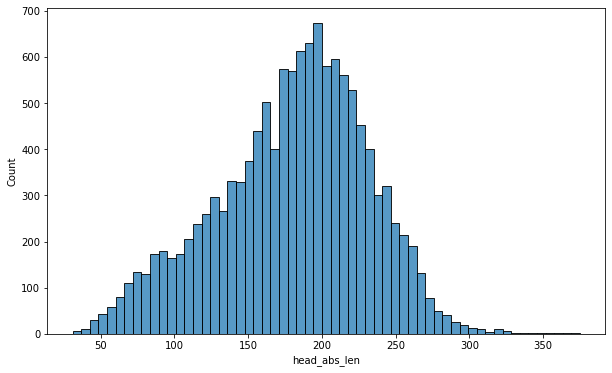

In [36]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='head_abs_len');

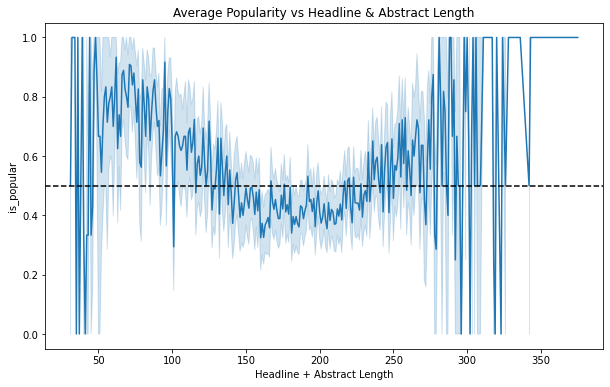

In [37]:
plt.figure(figsize=(10,6))
sns.lineplot(data=train, x='head_abs_len', y='is_popular')
mean = train.groupby('head_abs_len').mean()['is_popular'].mean()
plt.axhline(0.5, color='black', ls='--')
#plt.axhline(mean, color='black', ls='--', label=f'Avg. Popularity: {mean:.2f}')
#plt.legend(fontsize=12);
plt.xlabel('Headline + Abstract Length')
plt.title('Average Popularity vs Headline & Abstract Length');

## News Desk

In [38]:
# Combining different newsdesk names
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'The Upshot' if x=='Upshot' else x)
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'OpEd' if x=='Opinion' else x)
train['newsdesk'] = train['newsdesk'].apply(lambda x: 'AtHome' if x=='At Home' else x)

These are the newsdesks with the most number of comments. Unsurprisingly, OpEd articles are at the top, followed by Foreign and Business. In 2017, the NYT implemented a [new commenting system](https://www.nytimes.com/2017/06/13/insider/have-a-comment-leave-a-comment.html) that opened up OpEd articles and other selected news articles for 24 hours. This is likely part of the reason why OpEd articles seem to draw a higher frequency of comments.

In [39]:
# Grouping largest 20 newsdesks and sorting by popularity
df = train['newsdesk'].value_counts(ascending=False).reset_index()
df.columns=['newsdesk', 'n_articles']
temp = pd.merge(df, train.groupby('newsdesk').mean()['is_popular'].reset_index()).head(10)
temp['n_articles'].sum()

7411

In [40]:
g_index = df['newsdesk'].head(20).values
g_df = train[train['newsdesk'].isin(g_index)]
g_data = g_df.groupby('newsdesk').mean()['is_popular'].sort_values(ascending=False)
g_data = g_data.to_frame().reset_index()
g_data.head()

,newsdesk,is_popular
0,OpEd,0.925140
1,Politics,0.793878
2,Games,0.782857
3,Washington,0.774510
4,The Upshot,0.720165


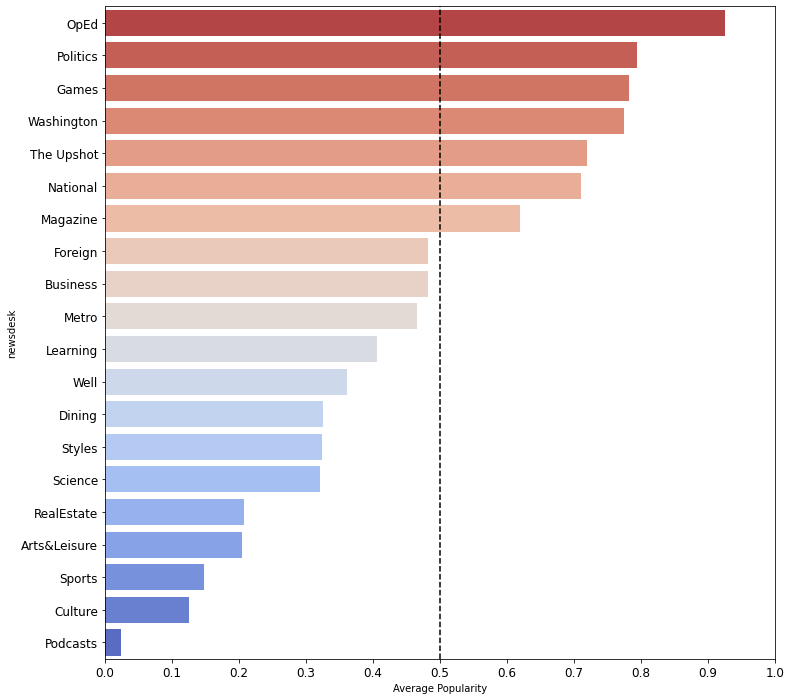

In [41]:
# Top 20 newsdesks
plt.figure(figsize=(12, 12))
sns.barplot(data=g_data, y=g_data['newsdesk'], x=g_data['is_popular'], orient='h', palette='coolwarm_r')
plt.xlabel('Average Popularity')
#plt.ylabel('Newsdesk')
plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=12)
plt.yticks(fontsize=12)
#plt.title('Newsdesk Avg. Popularity', fontsize=18);
plt.axvline(0.5, ls='--', color='black')
#plt.savefig(fname='newsdesk',dpi=180)

Some newsdesks have many more popular than unpopular articles such as OpEd, Politics, Games, and Washington. Other newsdesks have many more unpopular than popular articles, like Culture and Podcasts.

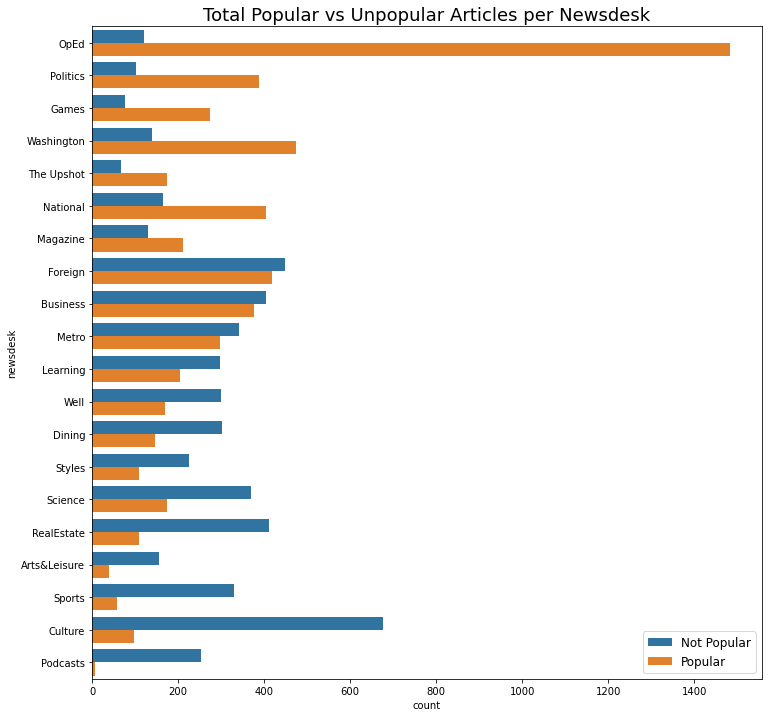

In [42]:
# Viewing top newsdesks by proportion of popularity
g_index = df['newsdesk'].head(20).values
g_df = train[train['newsdesk'].isin(g_index)]
order = g_df.groupby('newsdesk').mean()['is_popular'].sort_values(ascending=False).index
plt.figure(figsize=(12,12))
sns.countplot(data=g_df, y='newsdesk', hue='is_popular', order=order)
plt.legend(labels=['Not Popular', 'Popular'], fontsize=12, loc='best')
plt.title('Total Popular vs Unpopular Articles per Newsdesk', fontsize=18);

## Section

In [43]:
df = train['section'].value_counts(ascending=False).reset_index()
df.columns=['section', 'n_articles']

In [44]:
g_index = df['section'].head(20).values
g_df = train[train['section'].isin(g_index)]
g_data = g_df.groupby('section').mean()['is_popular'].sort_values(ascending=False)
g_data = g_data.to_frame().reset_index()

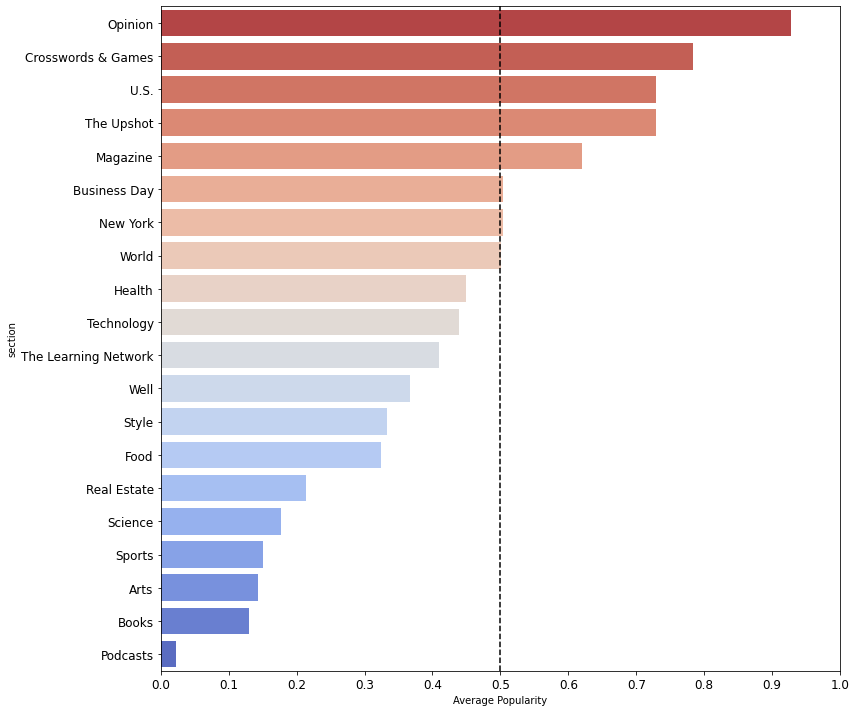

In [45]:
# Top 20 sections
plt.figure(figsize=(12, 10))
sns.barplot(data=g_data, y=g_data['section'], x=g_data['is_popular'], orient='h', palette='coolwarm_r')
plt.xlabel('Average Popularity')
#plt.ylabel('Section')
plt.yticks(fontsize=12)
plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=12)
#plt.title('Section Avg. Popularity', fontsize=18);
plt.axvline(0.5, ls='--', color='black')
plt.tight_layout()
#plt.savefig(fname='section', dpi=180)

Opinion is the most popular section, followed by Crossword & Games and U.S. Most OpEd newsdesk articles fall into the Opinion section, except for a couple that fall under Sunday Review.

In [46]:
train[(train['newsdesk'] == 'OpEd') & (train['section'] != 'Opinion')][['newsdesk', 'section', 'subsection', 
                                                                        'material', 'headline']]

,newsdesk,section,subsection,material,headline
1415,OpEd,Sunday Review,NaN,Op-Ed,What Does It Mean to Have a Serious Drinking P...
6181,OpEd,Sunday Review,NaN,Op-Ed,What We Lose When We Go From the Classroom to ...
7848,OpEd,Sunday Review,NaN,News Analysis,A ‘Glorious Poetic Rage’
9825,OpEd,Sunday Review,NaN,Op-Ed,Reopening Schools Is Way Harder Than It Should Be
10440,OpEd,Sunday Review,NaN,News Analysis,The Real Reason the American Economy Boomed Af...
11500,OpEd,Sunday Review,NaN,Op-Ed,We’re All Socially Awkward Now


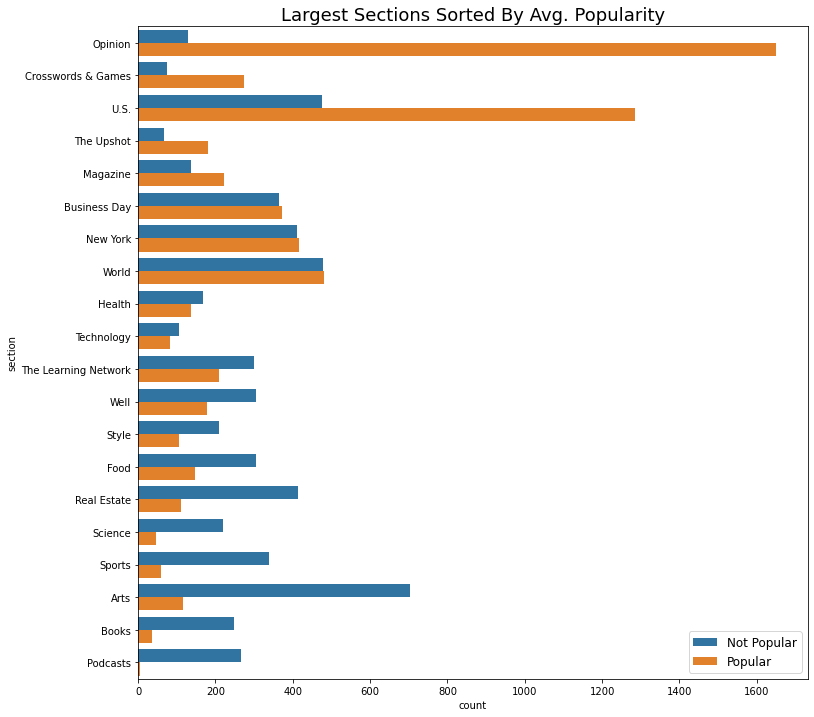

In [47]:
# Viewing top newsdesks by proportion of popularity
g_index = df['section'].head(20).values
g_df = train[train['section'].isin(g_index)]
order = g_df.groupby('section').mean()['is_popular'].sort_values(ascending=False).index
plt.figure(figsize=(12,12))
sns.countplot(data=g_df, y='section', hue='is_popular', order=order)
plt.legend(labels=['Not Popular', 'Popular'], fontsize=12, loc='best')
plt.title('Largest Sections Sorted By Avg. Popularity', fontsize=18);

## Subsection

In [48]:
train['subsection'] = train['subsection'].fillna('N/A')

In [49]:
df = train['subsection'].value_counts(ascending=False).reset_index()
df.columns=['subsection', 'n_articles']

In [50]:
g_index = df['subsection'].head(20).values
g_df = train[train['subsection'].isin(g_index)]
g_data = g_df.groupby('subsection').mean()['is_popular'].sort_values(ascending=False)
g_data = g_data.to_frame().reset_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Sunday Review'),
  Text(0, 1, 'Politics'),
  Text(0, 2, 'Move'),
  Text(0, 3, 'Economy'),
  Text(0, 4, 'N/A'),
  Text(0, 5, 'Media'),
  Text(0, 6, 'Middle East'),
  Text(0, 7, 'Europe'),
  Text(0, 8, 'Live'),
  Text(0, 9, 'Asia Pacific'),
  Text(0, 10, 'Family'),
  Text(0, 11, 'Wine, Beer & Cocktails'),
  Text(0, 12, 'Pro Football'),
  Text(0, 13, 'Music'),
  Text(0, 14, 'Baseball'),
  Text(0, 15, 'Television'),
  Text(0, 16, 'Book Review'),
  Text(0, 17, 'Art & Design'),
  Text(0, 18, 'Pro Basketball'),
  Text(0, 19, 'The Daily')])

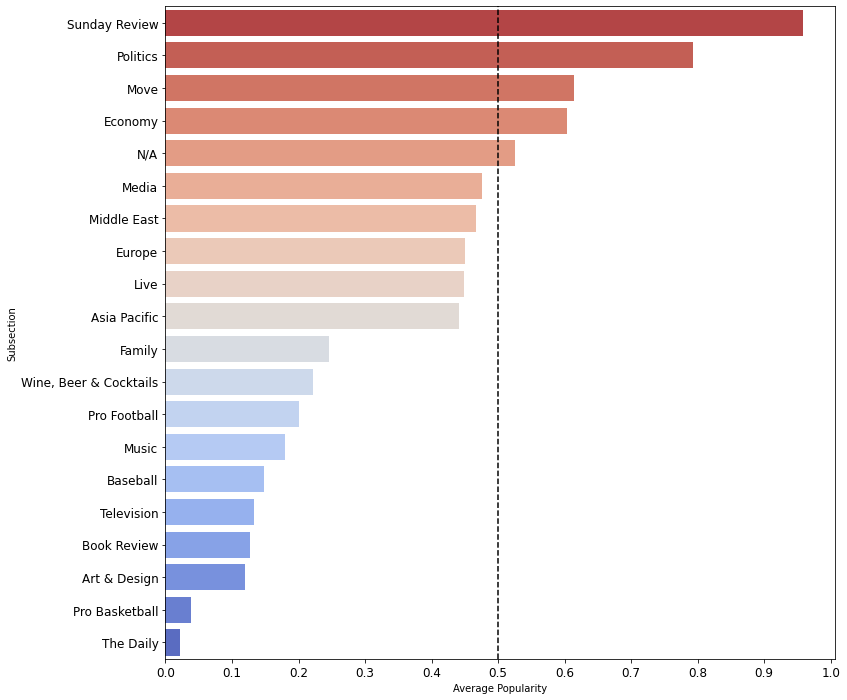

In [51]:
# Top 20 sections
plt.figure(figsize=(12, 12))
sns.barplot(data=g_data, y=g_data['subsection'], x=g_data['is_popular'], orient='h', palette='coolwarm_r')
plt.xlabel('Average Popularity')
plt.ylabel('Subsection')
plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=12)
#plt.title('Subsection Avg. Popularity', fontsize=18)
plt.axvline(0.5, ls='--', color='black')
plt.yticks(fontsize=12)
#plt.savefig(fname='subsection', dpi=180);

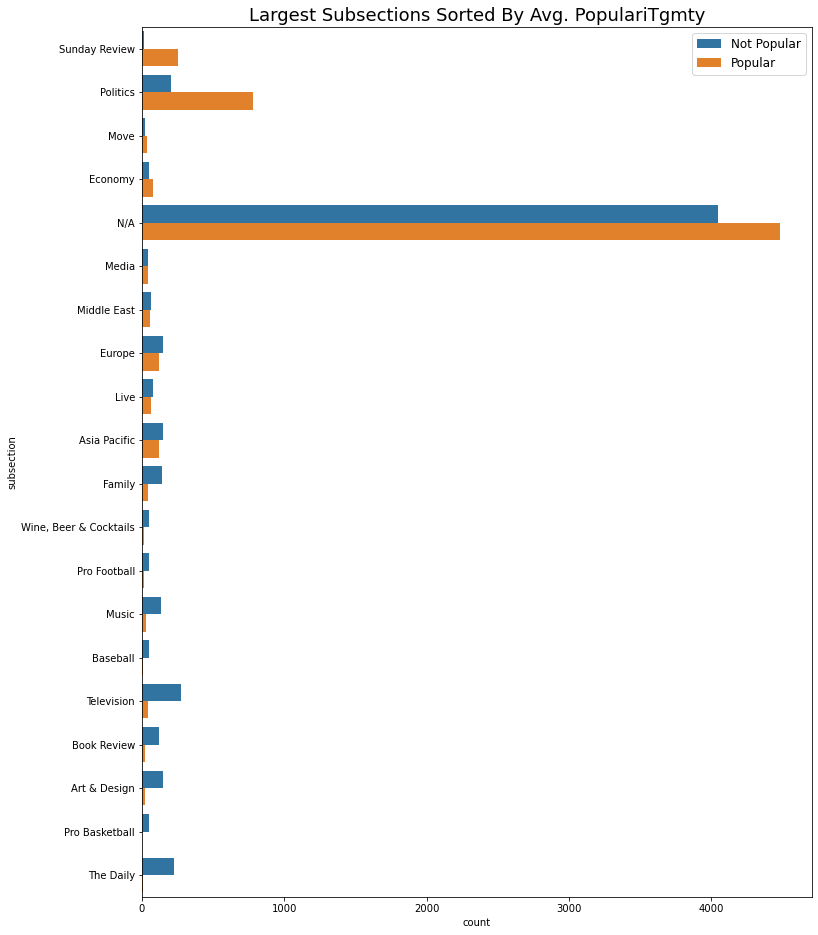

In [52]:
# Viewing top newsdesks by proportion of popularity
g_index = df['subsection'].head(20).values
g_df = train[train['subsection'].isin(g_index)]
order = g_df.groupby('subsection').mean()['is_popular'].sort_values(ascending=False).index
plt.figure(figsize=(12,16))
sns.countplot(data=g_df, y='subsection', hue='is_popular', order=order)
plt.legend(labels=['Not Popular', 'Popular'], fontsize=12, loc='best')
plt.title('Largest Subsections Sorted By Avg. PopulariTgmty', fontsize=18);

## Material

In [53]:
df = train['material'].value_counts(ascending=False)
df = df.drop(['Letter', 'List']).reset_index()
df.columns=['material', 'n_articles']

In [54]:
g_index = df['material'].head(20).values
g_df = train[train['material'].isin(g_index)]
g_data = g_df.groupby('material').mean()['is_popular'].sort_values(ascending=False)
g_data = g_data.to_frame().reset_index()

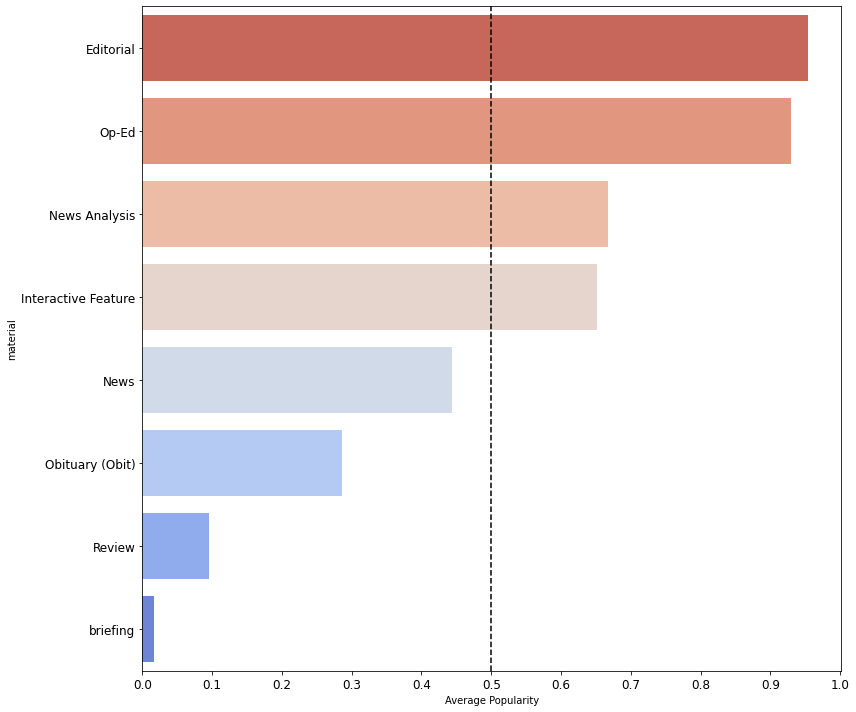

In [55]:
# Top 20 sections
plt.figure(figsize=(12, 10))
sns.barplot(data=g_data, y=g_data['material'], x=g_data['is_popular'], orient='h', palette='coolwarm_r')
plt.xlabel('Average Popularity')
#plt.ylabel('Material')
plt.yticks(fontsize=12)
plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=12)
#plt.title('Top 8 Material', fontsize=18)
plt.axvline(0.5, ls='--', color='black')
plt.tight_layout()
#plt.savefig(fname='material')

## Keywords

In [56]:
train['keywords']

0        [Veterans, For-Profit Schools, Financial Aid (...
1                                      [Crossword Puzzles]
2        [Meteors and Meteorites, Space and Astronomy, ...
3        [Space and Astronomy, Moon, Eclipses, Seasons ...
4        [Space and Astronomy, Private Spaceflight, Roc...
                               ...                        
12787    [Russia, Putin, Vladimir V, Coronavirus (2019-...
12788    [Presidential Election of 2020, Debates (Polit...
12789    [Presidential Election of 2020, Debates (Polit...
12790    [Trump, Donald J, Republican Party, Whites, Ri...
12791    [Presidential Election of 2020, Absentee Votin...
Name: keywords, Length: 12792, dtype: object

In [57]:
keyword_df = pd.DataFrame(train['keywords'].values.tolist(), index=train.index)

In [58]:
keyword_df = keyword_df.stack().reset_index()

In [59]:
keyword_df[0].value_counts().head(5)

Coronavirus (2019-nCoV)                  4403
Trump, Donald J                          2061
United States Politics and Government    1980
Presidential Election of 2020            1334
Quarantines                               961
Name: 0, dtype: int64

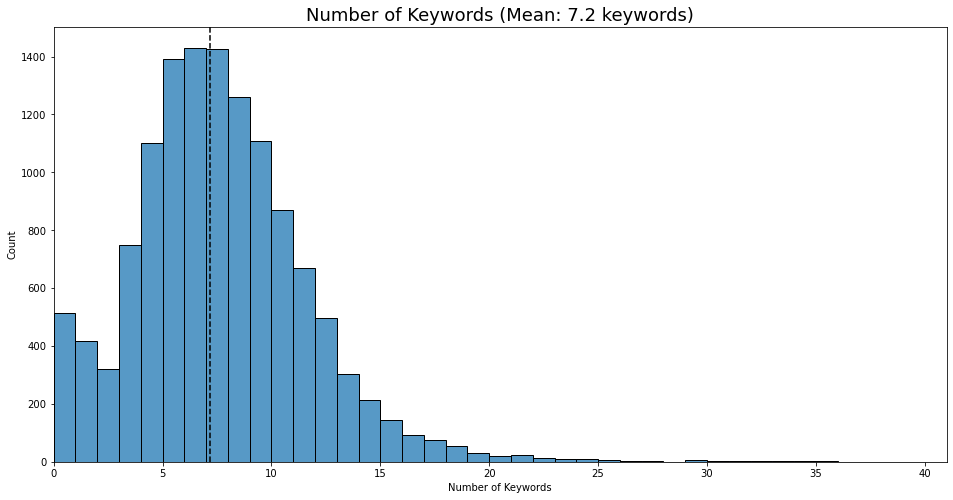

In [60]:
train['n_keywords'] = train['keywords'].apply(lambda x: len(x))
mean = train['n_keywords'].mean()

plt.figure(figsize=(16,8))
plt.axvline(mean, ls='--', color='black')
sns.histplot(train['n_keywords'], bins=60)
plt.xlabel('Number of Keywords')
plt.xlim(0, 41)
plt.title(f'Number of Keywords (Mean: {mean:.1f} keywords)', fontsize=18);

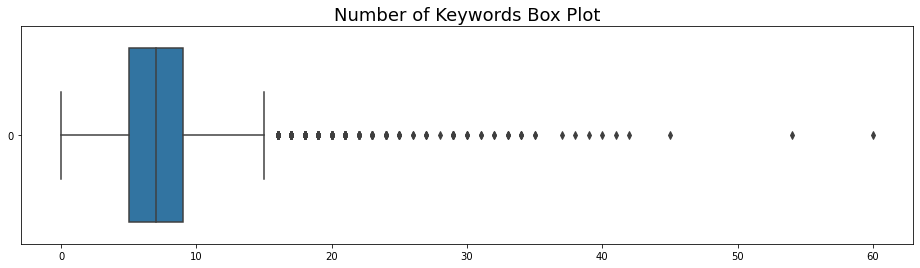

In [61]:
plt.figure(figsize=(16,4))
sns.boxplot(data=train['n_keywords'], orient='h')
plt.title('Number of Keywords Box Plot', fontsize=18);

In [62]:
# Looking at articles with more than 40 keywords
train[train['n_keywords'] > 40][['newsdesk', 'section', 'material', 'headline', 'n_keywords', 'is_popular']]

,newsdesk,section,material,headline,n_keywords,is_popular
328,Travel,Travel,Interactive Feature,52 Places to Go in 2020,54,1
3692,Arts,Arts,Interactive Feature,35 Top African-American Artists on the Work Th...,60,0
4315,BookReview,Books,News,Finding Comfort in the Classics,41,0
5155,Summary,Reader Center,News,One Bright Thing,42,0
6140,Summary,Reader Center,News,One Bright Thing: Reader Edition,45,0


In [63]:
# There are only 2210 articles with more than 10 keywords
train['n_keywords'].value_counts()[train['n_keywords'].value_counts().index > 10].sum()

2201

In [64]:
# There are only 370 articles with more than 15 keywords
train['n_keywords'].value_counts()[train['n_keywords'].value_counts().index > 15].sum()

370

In [65]:
g4_df = train.groupby('n_keywords').mean().reset_index().drop(columns='word_count')

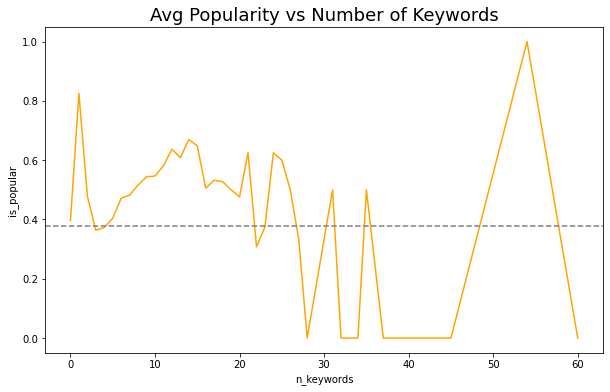

In [66]:
plt.figure(figsize=(10,6))
sns.lineplot(data=g4_df, x='n_keywords', y='is_popular', color='orange')
plt.axhline(train.groupby('n_keywords').mean()['is_popular'].mean(), color='gray', ls='--')
plt.title('Avg Popularity vs Number of Keywords', fontsize=18);

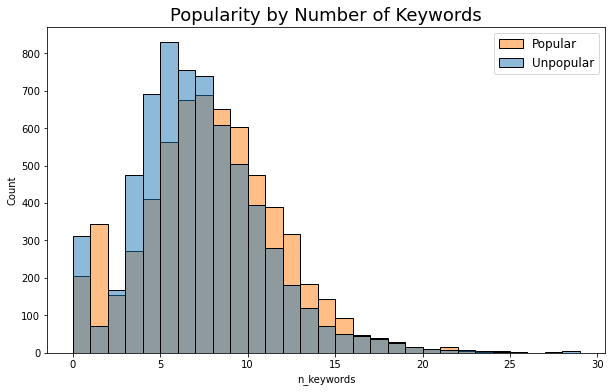

In [67]:
plt.figure(figsize=(10,6))
sns.histplot(data=train[train['n_keywords'] < 30], x='n_keywords', hue='is_popular', bins=np.arange(0,30))
plt.legend(labels=['Popular', 'Unpopular'], fontsize=12)
plt.title('Popularity by Number of Keywords', fontsize=18);

In [68]:
# There's a faint positive correlation between number of keywords and popularity
train.corr()['is_popular']

word_count         0.171316
is_popular         1.000000
word_count_log     0.065488
word_count_box     0.162656
word_count_sqrt    0.169339
headline_len      -0.001611
abstract_len      -0.104951
head_abs_len      -0.086333
n_keywords         0.072866
Name: is_popular, dtype: float64

## Time Variables

In this section, we're going to look at how time affects both the frequency and popularity of articles.

In [69]:
train['day_of_month'] = train['pub_date'].apply(lambda x: x.day)
train['month'] = train['pub_date'].apply(lambda x: x.month)
train['day_of_week'] = train['pub_date'].apply(lambda x: x.dayofweek)
train['hour'] = train['pub_date'].apply(lambda x: x.hour)
train['ymd'] = train['pub_date'].apply(lambda x: str(x)[:10])
train['ymd'] = pd.to_datetime(train['ymd'])

In [70]:
train['is_trump'] = train['keywords'].apply(lambda x: 1 if 'Trump, Donald J' in x else 0)
train['is_covid'] = train['keywords'].apply(lambda x: 1 if 'Coronavirus (2019-nCoV)' in x \
                                            else 1 if 'Coronavirus Risks and Safety Concerns' in x 
                                            else 0)
train['is_racial'] = train['keywords'].apply(lambda x: 1 if 'Black People' in x 
                                                else 1 if 'Race and Ethnicity' in x 
                                                else 1 if 'Discrimination' in x
                                                else 1 if 'Black Lives Matter Movement' in x
                                                else 0)

We can see that the news cycle here is somewhat cyclical -- within a single month, there are multiple peaks and valleys where the amount of news rapidly increases before falling. This pattern is consistent throughout the year.

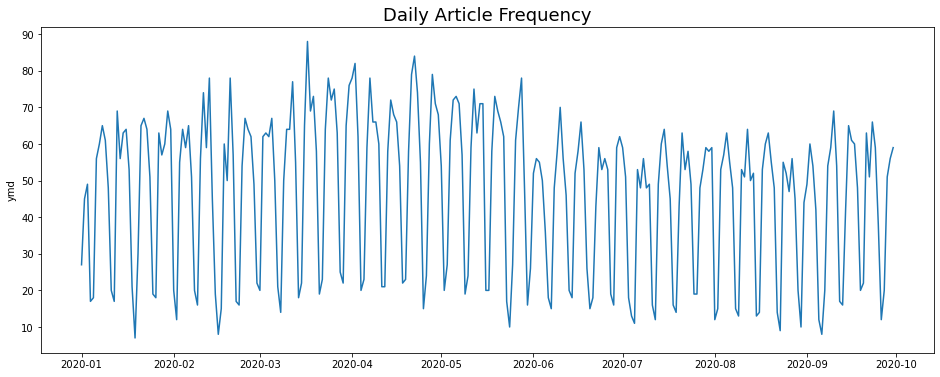

In [71]:
plt.figure(figsize=(16,6))
sns.lineplot(data=train['ymd'].value_counts())
plt.title('Daily Article Frequency', fontsize=18);
#plt.xlim('2020-03', '2020-05');

Article frequency differs by topic -- we can see there were much more articles about COVID-19 over the past year than any other news topic.

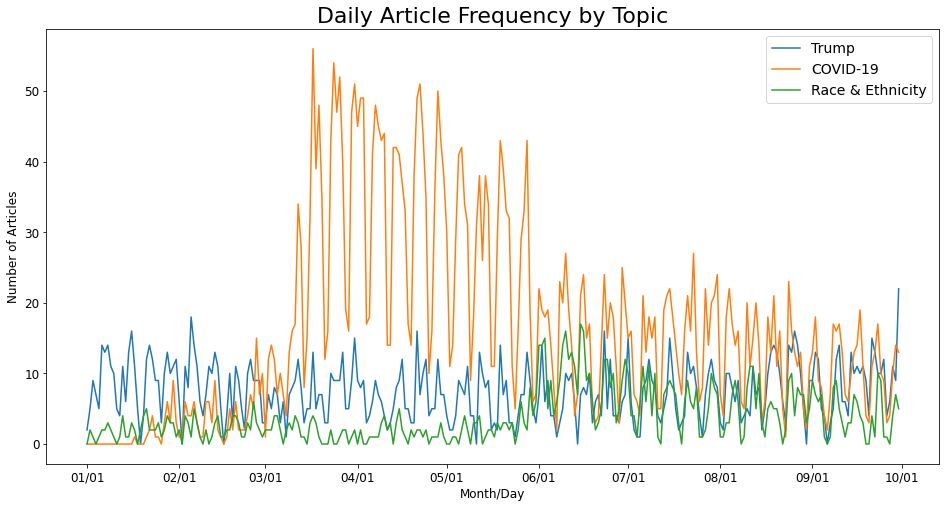

In [72]:
g1_data = train.groupby('ymd').sum().reset_index()
plt.figure(figsize=(16,8))
sns.lineplot(data=g1_data, x='ymd', y='is_trump', label='Trump')
sns.lineplot(data=g1_data, x='ymd', y='is_covid', label='COVID-19')
sns.lineplot(data=g1_data, x='ymd', y='is_racial', label='Race & Ethnicity')
plt.legend(fontsize=14)
plt.ylabel('Number of Articles', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Month/Day', fontsize=12)
plt.title('Daily Article Frequency by Topic', fontsize=22);
plt.xticks(ticks=['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
           '2020-08-01', '2020-09-01', '2020-10-01'], 
           labels=['01/01', '02/01', '03/01', '04/01', '05/01', '06/01', '07/01',
           '08/01', '09/01', '10/01'], fontsize=12);
#plt.xlim('2020-03', '2020-05');

### Month

Articles that were published in January, July, August and September have a slightly higher average popularity.

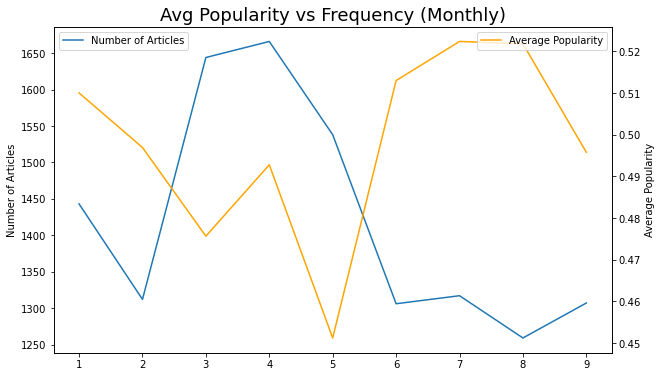

In [73]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=train['month'].value_counts(), label='Number of Articles')
ax.set_ylabel('Number of Articles')
ax.legend(loc=2)
ax2 = ax.twinx()
sns.lineplot(data=train.groupby('month').mean()['is_popular'], color='orange', ax=ax2, label='Average Popularity')
ax2.set_ylabel('Average Popularity')
ax2.legend(loc=1)
plt.title('Avg Popularity vs Frequency (Monthly)', fontsize=18);

### Day of Month

There doesn't appear to be a particular increase or decrease in popularity according to the day of the month

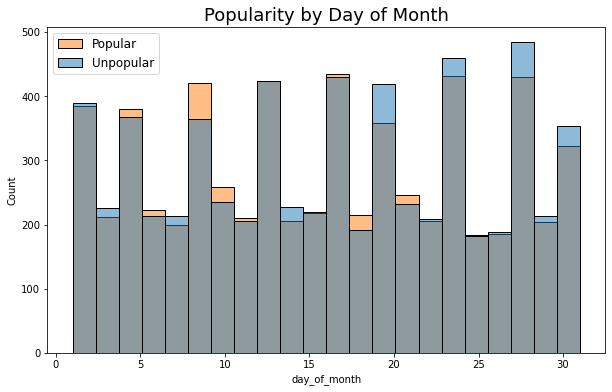

In [74]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='day_of_month', hue='is_popular')
plt.legend(labels=['Popular', 'Unpopular'], fontsize=12)
plt.title('Popularity by Day of Month', fontsize=18);

### Day of Week

There seems to be an inverse relationship between average popularity and the number articles opened for commentary. Average article popularity tends to be lower during the week, and higher on the weekend.

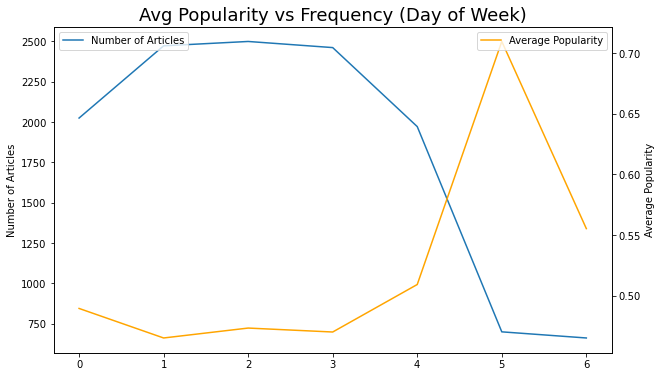

In [75]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=train['day_of_week'].value_counts(), label='Number of Articles')
ax.set_ylabel('Number of Articles')
ax.legend(loc=2)
ax2 = ax.twinx()
sns.lineplot(data=train.groupby('day_of_week').mean()['is_popular'], color='orange', ax=ax2, label='Average Popularity')
ax2.set_ylabel('Average Popularity')
ax2.legend(loc=1)
plt.title('Avg Popularity vs Frequency (Day of Week)', fontsize=18);

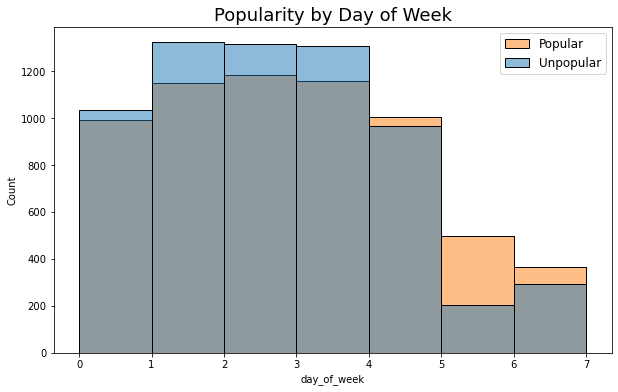

In [76]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='day_of_week', hue='is_popular', bins = np.arange(0, 8))
plt.legend(labels=['Popular', 'Unpopular'], fontsize=12)
plt.title('Popularity by Day of Week', fontsize=18);

### Hour

Articles published between 10pm and 2am have a much higher average popularity.

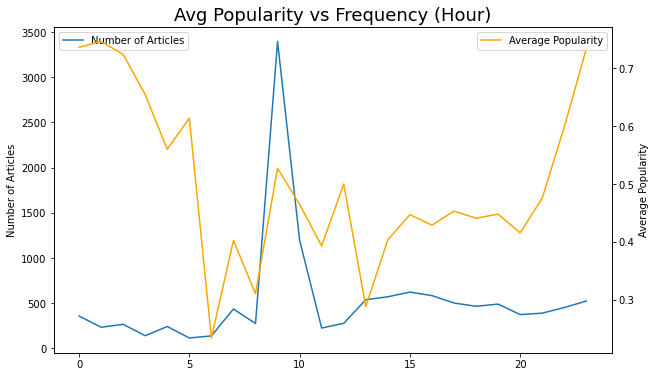

In [77]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=train['hour'].value_counts(), label='Number of Articles')
ax.set_ylabel('Number of Articles')
ax.legend(loc=2)
ax2 = ax.twinx()
sns.lineplot(data=train.groupby('hour').mean()['is_popular'], color='orange', ax=ax2, label='Average Popularity')
ax2.set_ylabel('Average Popularity')
ax2.legend(loc=1)
plt.title('Avg Popularity vs Frequency (Hour)', fontsize=18);

Text(0.5, 1.0, 'Popularity by Hour')

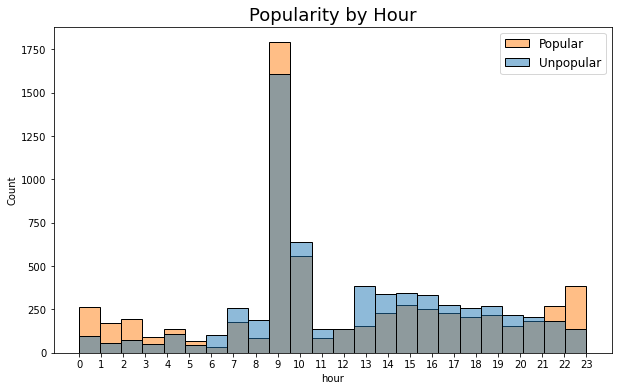

In [78]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='hour', hue='is_popular', bins=24)
plt.xticks(np.arange(0, 24, 1))
plt.legend(labels=['Popular', 'Unpopular'], fontsize=12)
plt.title('Popularity by Hour', fontsize=18)